In [11]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [7]:
## This is the method we use to get around memory issues. To implement, use:
## dask-scheduler # get the tcp code from this call in a jupyter new terminal, then run command below in a another terminal
## dask-worker tcp://10.0.64.4:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
client=Client('tcp://10.0.64.13:8786', local_dir='/local/v45/pas561')
client

Client Scheduler: tcp://10.0.64.13:8786 Dashboard: http://10.0.64.13:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [25]:
#create land sea mask
##old fashioned way
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle/output048/ocean'

Ocean_File = os.path.join(NYFCntrlDir,'ocean_grid.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False).load()
kmu=cntrl.kmu[0].load()
print(kmu.shape)

msk=np.zeros((kmu.shape[0],kmu.shape[1]),dtype=float)
msk.fill(np.nan)
msk[np.where(kmu>=1)]=1

/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle/output048/ocean/ocean_grid.nc
(300, 360)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
 ------ Here is what the initial dataset looks like ------ 
<xarray.DataArray 'tx_trans_int_z' (time: 720, yt_ocean: 300, xu_ocean: 360)>
dask.array<shape=(720, 300, 360), dtype=float32, chunksize=(1, 300, 360)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * xu_ocean  (xu_ocean) float64 -279.0 -278.0 -277.0 -276.0 ... 78.0 79.0 80.0
  * time      (time) datetime64[ns] 1958-01-17T12:00:00 ... 2017-12-16T12:00:00
Attributes:
    long_name:      T-cell i-mass transport vertically summed
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_t
 --------------------------------------------------------- 
 
 ------ Here is what the resampled dataset looks like ------ 
<xarray.DataArray 'tx_trans_int_z' (time: 60, yt_ocean: 300, xu_ocean: 3

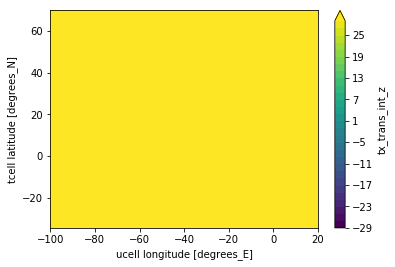

In [26]:
expt = '1deg_jra55v13_iaf_spinup1_B1'  ## choosing our 1 degree experiment
n_files = -12                          ## Last 12 files is last 60 years
time_units = 'days since 1718-01-01'   ## These are to give correct dates
offset = -87658

## Load monthly zonal barotropic transport
tx_trans_int_z = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                                        n=n_files,time_units=time_units, offset=offset)

print(' ------ Here is what the initial dataset looks like ------ ')
print(tx_trans_int_z)
print(' --------------------------------------------------------- ')
print(' ')

tx_trans_annual = tx_trans_int_z.resample(time='A').mean('time')

print(' ------ Here is what the resampled dataset looks like ------ ')
print(tx_trans_annual)
print(' --------------------------------------------------------- ')
print(' ')

BSF = tx_trans_annual.cumsum('yt_ocean')/1e6/1036
BSF = BSF - BSF.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')

## Chop out the area I'm interested in
BSF_NAtl = BSF.sel(xu_ocean = slice(-100,20)).sel(yt_ocean = slice(-35,70))
print(' ------ Here is what the North Atl dataset looks like ------ ')
print(BSF_NAtl)
print(' --------------------------------------------------------- ')
print(' ')

BSF=-BSF*msk

## Plot the mean for the North Atlantic region
BSF_NAtl.mean('time').plot.contourf(levels=np.arange(-29,30,2))

## Save the whole dataset
BSF.to_netcdf('BSF_1deg.nc')


In [27]:
#create land sea mask
##old fashioned way
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output153/ocean'

Ocean_File = os.path.join(NYFCntrlDir,'ocean_grid.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False).load()
kmu=cntrl.kmu[0].load()
print(kmu.shape)

msk=np.zeros((kmu.shape[0],kmu.shape[1]),dtype=float)
msk.fill(np.nan)
msk[np.where(kmu>=1)]=1

/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output153/ocean/ocean_grid.nc
(1080, 1440)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
 ------ Here is what the initial dataset looks like ------ 
<xarray.DataArray 'tx_trans_int_z' (time: 720, yt_ocean: 1080, xu_ocean: 1440)>
dask.array<shape=(720, 1080, 1440), dtype=float32, chunksize=(1, 540, 720)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * time      (time) datetime64[ns] 1958-01-15T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      T-cell i-mass transport vertically summed
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_t
 --------------------------------------------------------- 
 
 ------ Here is what the resampled dataset looks like ------ 
<xarray.DataArray 'tx_trans_int_z' (time: 60, yt_ocean: 1080, xu_oc

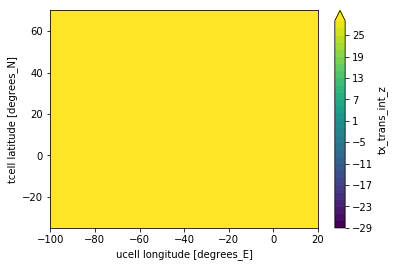

In [28]:
expt = '025deg_jra55v13_iaf_gmredi6'
n_files = -34                          ## Last 30 files is last 60 years
time_units = 'days since 1718-01-01'   ## These are to give correct dates
offset = -87658

## Load monthly zonal barotropic transport
tx_trans_int_z = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                                        n=n_files,time_units=time_units, offset=offset)

print(' ------ Here is what the initial dataset looks like ------ ')
print(tx_trans_int_z)
print(' --------------------------------------------------------- ')
print(' ')

tx_trans_annual = tx_trans_int_z.resample(time='A').mean('time')

print(' ------ Here is what the resampled dataset looks like ------ ')
print(tx_trans_annual)
print(' --------------------------------------------------------- ')
print(' ')

BSF = tx_trans_annual.cumsum('yt_ocean')/1e6/1036
#BSF = BSF - BSF.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')

## Chop out the area I'm interested in
BSF_NAtl = BSF.sel(xu_ocean = slice(-100,20)).sel(yt_ocean = slice(-35,70))
print(' ------ Here is what the North Atl dataset looks like ------ ')
print(BSF_NAtl)
print(' --------------------------------------------------------- ')
print(' ')

BSF=-BSF*msk

## Plot the mean for the North Atlantic region
BSF_NAtl.mean('time').plot.contourf(levels=np.arange(-29,30,2))

## Save the whole dataset
BSF.to_netcdf('BSF_025deg_no0.nc')

In [22]:
#create land sea mask
##old fashioned way
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output001/ocean'

Ocean_File = os.path.join(NYFCntrlDir,'ocean_grid.nc')
print(Ocean_File)
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False).load()
kmu=cntrl.kmu[0].load()
print(kmu.shape)

msk=np.zeros((kmu.shape[0],kmu.shape[1]),dtype=float)
msk.fill(np.nan)
msk[np.where(kmu>=1)]=1

/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output001/ocean/ocean_grid.nc
(2700, 3600)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
 ------ Here is what the initial dataset looks like ------ 
<xarray.DataArray 'tx_trans_int_z' (time: 396, yt_ocean: 2700, xu_ocean: 3600)>
dask.array<shape=(396, 2700, 3600), dtype=float32, chunksize=(1, 675, 900)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * time      (time) datetime64[ns] 1985-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      T-cell i-mass transport vertically summed
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_t
 --------------------------------------------------------- 
 
 ------ Here is what the resampled dataset looks like ------ 
<xarray.DataArray 'tx_trans_int_z' (time: 33, yt_ocean: 2700, xu_oce

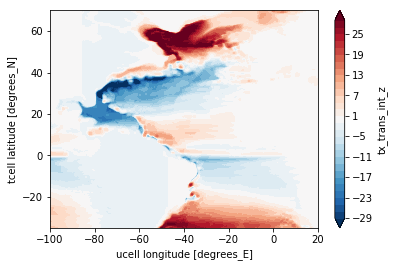

In [24]:
expt = '01deg_jra55v13_iaf'
n_files = None                          ## For Testing
time_units = 'days since 0001-01-01'   ## These are to give correct dates
offset = None

## Load monthly zonal barotropic transport
tx_trans_int_z = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                                        n=n_files,time_units=time_units, offset=offset)

print(' ------ Here is what the initial dataset looks like ------ ')
print(tx_trans_int_z)
print(' --------------------------------------------------------- ')
print(' ')

tx_trans_annual = tx_trans_int_z.resample(time='A').mean('time')

print(' ------ Here is what the resampled dataset looks like ------ ')
print(tx_trans_annual)
print(' --------------------------------------------------------- ')
print(' ')

BSF = tx_trans_annual.cumsum('yt_ocean')/1e6/1036
BSF = BSF - BSF.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')

## Chop out the area I'm interested in
BSF_NAtl = BSF.sel(xu_ocean = slice(-100,20)).sel(yt_ocean = slice(-35,70))
print(' ------ Here is what the North Atl dataset looks like ------ ')
print(BSF_NAtl)
print(' --------------------------------------------------------- ')
print(' ')

BSF=-BSF*msk

## Plot the mean for the North Atlantic region
BSF_NAtl.mean('time').plot.contourf(levels=np.arange(-29,30,2))

## Save the whole dataset
BSF.to_netcdf('BSF_01deg.nc')